In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [2]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
## get data, just Close values
import readcsv
data = readcsv.get_data(cols=['Close'], verbose=True).astype(np.float32)
print(data.shape)

0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
2 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
3 Data/Bond-MoodyBAA(MOCBAAD).csv Close
4 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
5 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
6 Data/Commod-GoldPrice(__XAU_D).csv Close
7 Data/Commod-OilPrice(__WTC_D).csv Close
8 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
9 Data/Commod-ReutersCRBIndustrialRaw(CMCRBIND).csv Close
10 Data/Commod-ReutersCRBmetal(CMCRBMED).csv Close
11 Data/Employ-EuropeUnemploymentRate(UNEUR19M).csv Close
12 Data/Employ-USInitialClaimsForUnemploymentInsurance(USICSAM).csv Close
13 Data/Employ-USTotalNonfarmPayroll(USPAYEMSM).csv Close
14 Data/Employ-USUnemploymentRate(UNUSAM).csv Close
15 Data/ExRate-DollarNominalEffectiveExchangeRate(XRNUSAM).csv Close
16 Data/ExRate-EuroNominalEffectiveExchangeRate(XRNEURM).csv Close
17 Data/ExRate-PoundPerDollar(USDGBP).csv Close
18 Data/ExRate-YenPerDollar(USDJPY).csv

In [4]:
## indicators to use when training
keeplist = [0, 1, 5, 15, 16, 25, 27]

In [5]:
## ===== Preprocessing ==============================
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

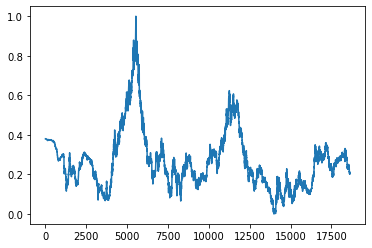

In [6]:
## visualize data
plt.plot(data[:,0])
plt.show()

In [7]:
def generate_batches(data, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X: shape = (B, len(learn_window), C)
    - y: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window]
        y[k] = data[i+Lcap+predict_window, 0] ## USD-EUR Close is index 0
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, 7, np.arange(50), np.arange(5))

X, y = next(G)
print(X.shape)
print(y.shape)

(7, 50, 54)
(7, 5)


# Predict next day
Given 30-day history of USD-EUR closing, predict next day closing.
Should expect good performance since linear regression is pretty good at this.

In [7]:
## split into training and testing sets
data_train = data[:-2000, 0:1]
data_test = data[-2000:, 0:1]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (16628, 1)
Testing: (2000, 1)


In [8]:
## ===== model hyperparameters ======================
learn_window = np.arange(30)    ## learn from past 30 days
predict_window = np.arange(1)   ## predict next day

batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1d = models.Sequential()
model_1d.add(layers.GRU(64, input_shape=(L, C)))
model_1d.add(layers.Dense(P))
model_1d.compile(optimizer=opt, loss='mse')
model_1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [9]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [10]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_1d.fit(X, y, batch_size=1)
model_1d.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 1s/sample - loss: 0.0638


0.06375278532505035

In [11]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_test, y_test))

Train for 300 steps, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 38s 127ms/step - loss: 0.0018 - val_loss: 2.6782e-05
Epoch 2/10
300/300 [==============================] - 32s 106ms/step - loss: 5.7057e-05 - val_loss: 2.5030e-05
Epoch 3/10
300/300 [==============================] - 27s 92ms/step - loss: 4.9029e-05 - val_loss: 2.3979e-05
Epoch 4/10
300/300 [==============================] - 28s 92ms/step - loss: 4.6758e-05 - val_loss: 2.0658e-05
Epoch 5/10
300/300 [==============================] - 28s 93ms/step - loss: 4.3207e-05 - val_loss: 2.1052e-05
Epoch 6/10
300/300 [==============================] - 25s 84ms/step - loss: 4.2412e-05 - val_loss: 2.5603e-05
Epoch 7/10
300/300 [==============================] - 25s 84ms/step - loss: 3.9842e-05 - val_loss: 2.5316e-05
Epoch 8/10
300/300 [==============================] - 30s 100ms/step - loss: 4.1096e-05 - val_loss: 1.8151e-05
Epoch 9/10
300/300 [==============================] - 30s 99ms/step - loss: 

comment: it looks like validation loss is less than training loss. This is actually due to the fact that the training data is just harder to model than the testing data. This is not a bug, since if I validate on the testing data I get roughly similar losses. At least, this assures us that our model is not overfitting. Also, the training loss is a running average over the epoch, so is over-estimated in the beginning.

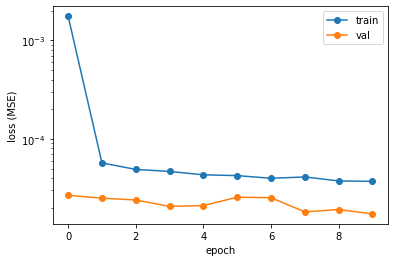

In [12]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
## test on all testing data
N, C = data_test.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_test[i+learn_window]
    y_detail[i] = data_test[i+Lcap+predict_window, 0]

y_predict = model_1d.predict(X_learn)

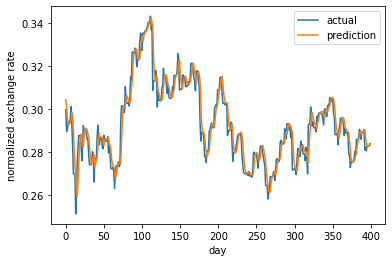

Average MSE: 1.855e-05


In [24]:
## visualize predictions

## pick any date interval, subset of [0, M]
dates = np.arange(0, 400)
#dates = np.arange(0, M)

plt.plot(y_detail[dates, 0], label='actual')
plt.plot(y_predict[dates, 0], label='prediction')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

ave_mse = np.mean(np.square(y_detail[:,0] - y_predict[:,0]))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE: %.3e" % ave_mse)

This is similar to linear regression, which has an average MSE = 1.046e-05 over the same dataset

# Predict future trend
Given 100-day USD-EUR closing, predict next 30-days. Try to beat linear regression predictions

In [8]:
## split into training and testing sets
data_train = data[:-2000, keeplist]
data_test = data[-2000:, keeplist]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (16628, 7)
Testing: (2000, 7)


In [10]:
## ===== model hyperparameters ======================
learn_window = np.arange(100)    ## learn from past 100 days
predict_window = np.arange(0, 30, 3)   ## predict next 30-days (10 trials)

batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
#opt = keras.optimizers.Adam(learning_rate=lr_schedule)
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_trend = models.Sequential()
model_trend.add(layers.GRU(200, return_sequences=True, input_shape=(L, C)))
model_trend.add(layers.Dropout(0.2))
model_trend.add(layers.GRU(200, return_sequences=True))
model_trend.add(layers.Dropout(0.2))
model_trend.add(layers.GRU(150))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mse')
model_trend.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 100, 200)          125400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 200)          241200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 150)               158400    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1510      
Total params: 526,510
Trainable params: 526,510
Non-trainable params: 0
________________________________________________

In [11]:
## initialize all input weights not accociated with USD-EUR to 0
weights = model_trend.layers[0].get_weights()
new_weight = np.zeros_like(weights[0])
new_weight[0] = weights[0][0]
model_trend.layers[0].set_weights( (new_weight, weights[1], weights[2]) )

In [11]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [12]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_trend.fit(X, y, batch_size=1)
model_trend.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 3s 3s/sample - loss: 0.0251


0.025123095139861107

In [13]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window)

model_trend.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_test, y_test))

Train for 300 steps, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 427s 1s/step - loss: 0.0017 - val_loss: 4.3220e-04
Epoch 2/10
300/300 [==============================] - 415s 1s/step - loss: 6.5030e-04 - val_loss: 6.0300e-04
Epoch 3/10
300/300 [==============================] - 416s 1s/step - loss: 5.6769e-04 - val_loss: 2.7717e-04
Epoch 4/10
300/300 [==============================] - 429s 1s/step - loss: 5.6390e-04 - val_loss: 2.4178e-04
Epoch 5/10
300/300 [==============================] - 419s 1s/step - loss: 5.1683e-04 - val_loss: 3.4517e-04
Epoch 6/10
300/300 [==============================] - 419s 1s/step - loss: 5.4472e-04 - val_loss: 2.4551e-04
Epoch 7/10
300/300 [==============================] - 424s 1s/step - loss: 5.0959e-04 - val_loss: 2.3473e-04
Epoch 8/10
300/300 [==============================] - 414s 1s/step - loss: 5.3072e-04 - val_loss: 2.2391e-04
Epoch 9/10
300/300 [==============================] - 417s 1s/step - loss: 4.9258e-04 -

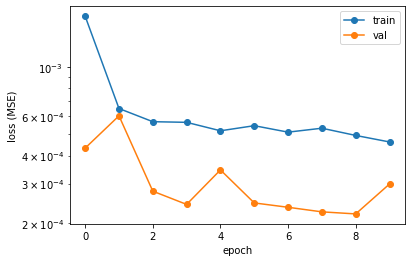

In [14]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
## test on all testing data
N, C = data_test.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

detail_window = np.arange(Pcap)

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_test[i+learn_window]
    y_detail[i] = data_test[i+Lcap+detail_window, 0]

y_predict = model_trend.predict(X_learn)

In [16]:
stream = np.zeros(M)
for i in range(M):
    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
    scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    mse *= scale_factor
    
    stream[i] = mse*scale_factor
    
print("Average MSE: %.3e" % np.mean(stream))

Average MSE: 2.252e-04


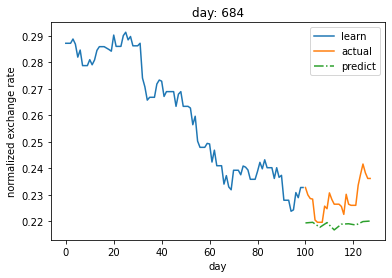

MSE: 1.187e-04


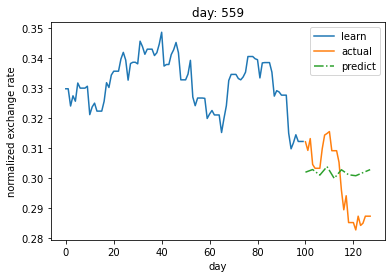

MSE: 1.384e-04


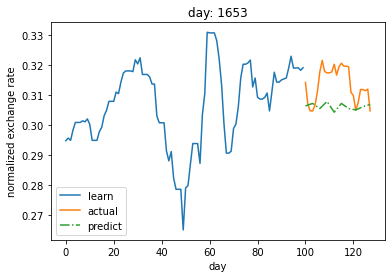

MSE: 9.143e-05


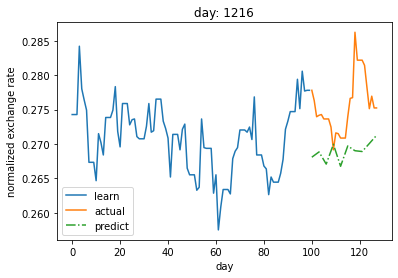

MSE: 6.702e-05


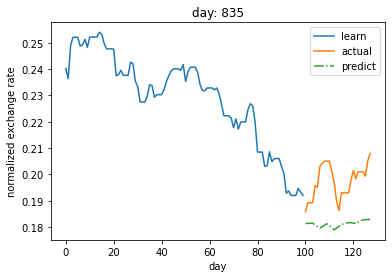

MSE: 2.836e-04


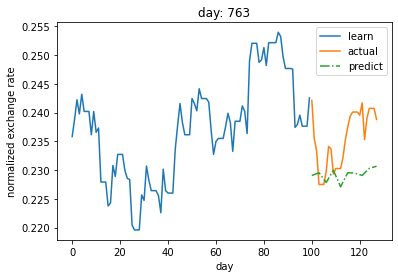

MSE: 6.558e-05


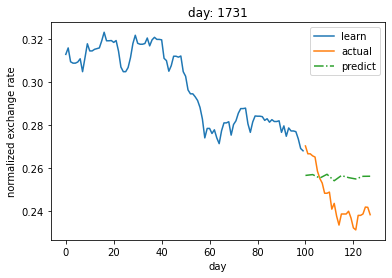

MSE: 2.046e-04


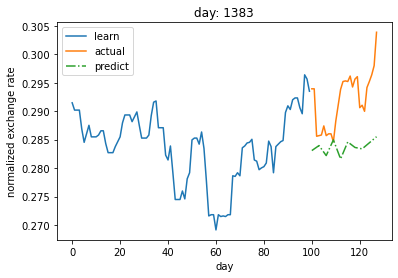

MSE: 9.829e-05


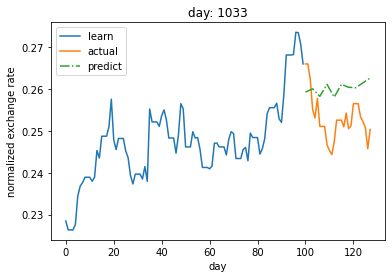

MSE: 8.141e-05


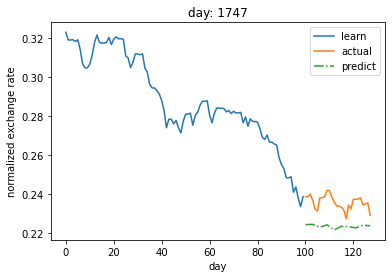

MSE: 1.570e-04


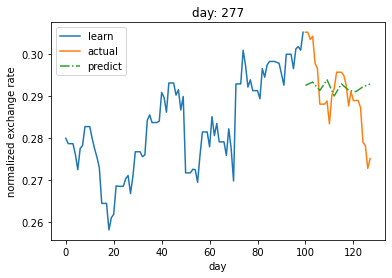

MSE: 7.773e-05


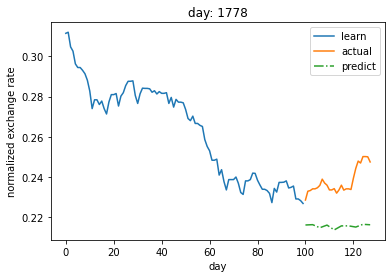

MSE: 5.077e-04


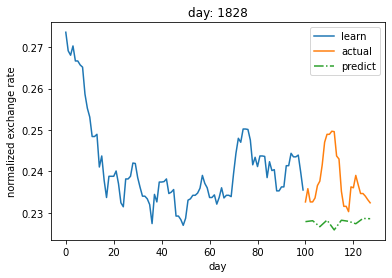

MSE: 1.311e-04


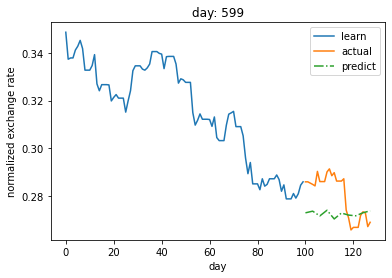

MSE: 1.281e-04


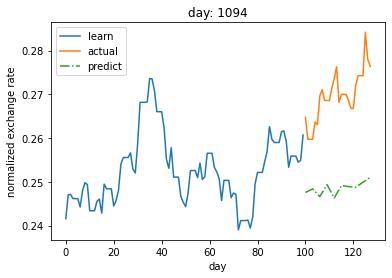

MSE: 4.374e-04


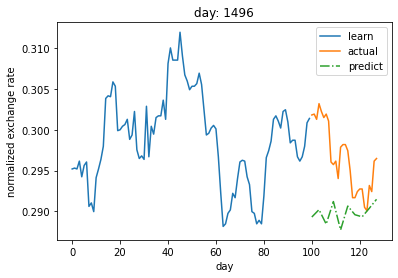

MSE: 6.801e-05


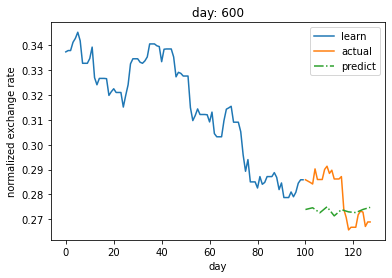

MSE: 1.125e-04


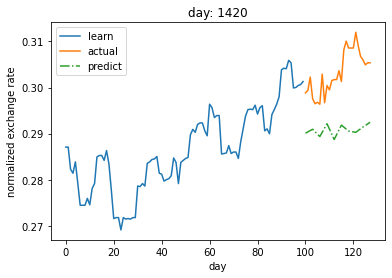

MSE: 1.561e-04


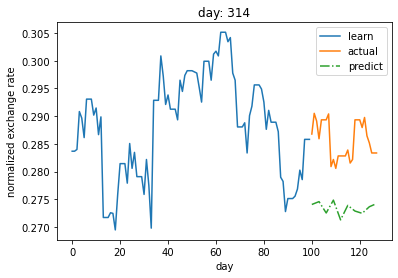

MSE: 1.485e-04


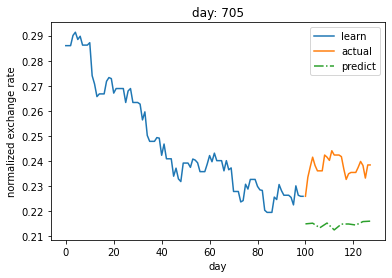

MSE: 5.121e-04


In [17]:
## visualize predictions
np.random.seed(0)
for i in np.random.randint(0, M, size=20):
    
    plt.plot(learn_window, X_learn[i, :, 0], label='learn')
    plt.plot(Lcap+detail_window, y_detail[i], label='actual')
    plt.plot(Lcap+predict_window, y_predict[i], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
    scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    mse *= scale_factor
    
    print("MSE: %.3e" % mse)

Seems that model just predicts a straight line. While this loss is technically lower than that of linear regression (Average MSE=2.530e-04 on same dataset), I don't think the model is learning anything meaningful. It is learning some sort of "jaggedness" from the data, however.

# Testing Code

In [ ]:
def test_generate_batches():
    data = np.arange(1000).reshape(-1, 1)
    print(data.shape)
    
    G = generate_batches(data, 1, [0, 10, 20, 30], [0, 10, 20, 30])
    
    for i in range(10):
        X, y = next(G)
        print(X[0,:,0], y[0])

test_generate_batches()